In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [41]:
df = pd.read_csv('CBOE_VIX_POST.csv', parse_dates=['Date'], index_col='Date')
print(df.shape)
df.tail()

(573, 4)


,Open,High,Low,Close
Date,,,,
2022-11-02,26.040001,26.620001,25.389999,25.860001
2022-11-03,25.980000,26.870001,25.100000,25.299999
2022-11-04,25.629999,25.709999,24.000000,24.549999
2022-11-07,25.670000,25.670000,24.340000,24.350000
2022-11-08,24.709999,26.160000,24.240000,25.540001


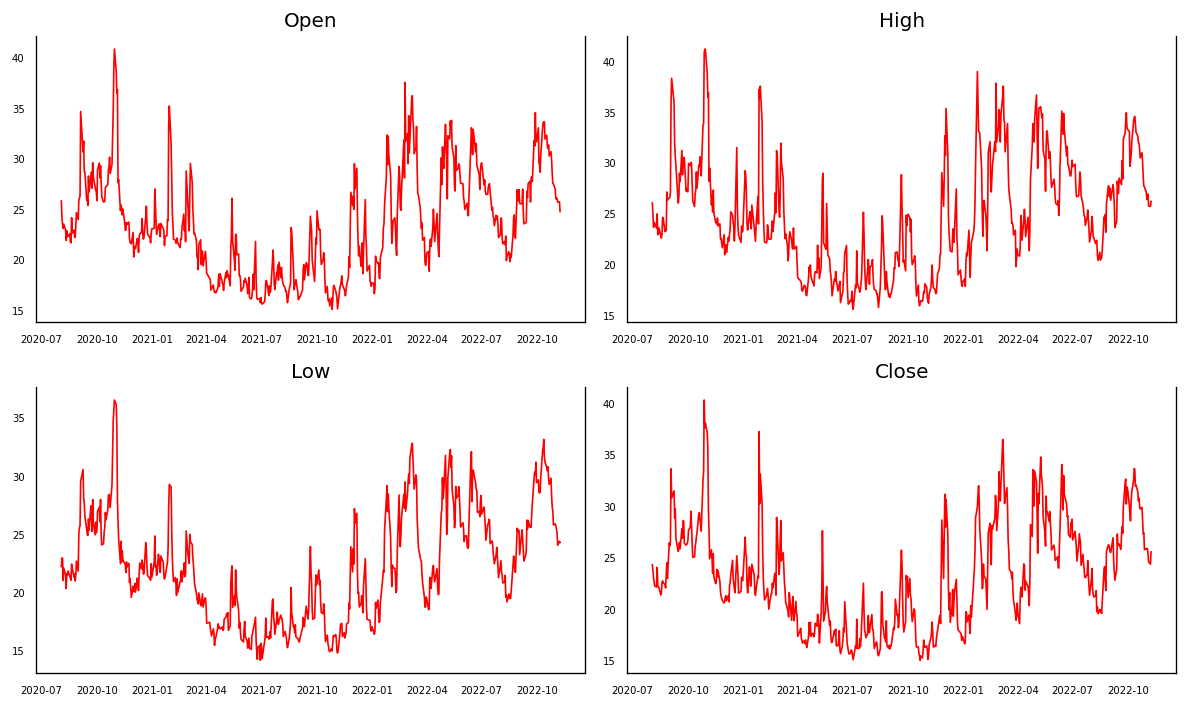

In [42]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [43]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Open_x,High_x,Low_x,Close_x
Open_y,1.0000,0.0000,0.0000,0.0
High_y,0.0012,1.0000,0.0000,0.0
Low_y,0.0000,0.0000,1.0000,0.0
Close_y,0.0113,0.2276,0.0001,1.0


In [44]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  229.34    > 40.1749   =>   True
High   ::  130.01    > 24.2761   =>   True
Low    ::  51.28     > 12.3212   =>   True
Close  ::  0.16      > 4.1296    =>   False


In [45]:
nobs = 228
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(345, 4)
(228, 4)


In [46]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [47]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1963
 No. Lags Chosen       = 3
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0202. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4862
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0083. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [87]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [104]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1963
 No. Lags Chosen       = 3
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0202. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4862
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0083. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [115]:
model = VAR(df_differenced)
x = model.select_order(maxlags=12)
x.summary()

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,AIC,BIC,FPE,HQIC
0,2.512,2.558,12.33,2.530
1,1.295,1.525,3.652,1.387
2,0.7072,1.120*,2.028,0.8717
3,0.5497,1.146,1.733,0.7874
4,0.4527,1.232,1.573,0.7635*
5,0.3893,1.352,1.477,0.7732
6,0.3520*,1.498,1.424*,0.8091
7,0.3578,1.687,1.433,0.8880
8,0.3526,1.865,1.427,0.9559
9,0.3803,2.077,1.468,1.057


In [116]:
model_fitted = model.fit(3)

In [117]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Open   : 2.09
High   : 2.02
Low    : 2.02
Close  : 2.01


In [119]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

In [120]:
# Forecast
fc = model_fitted.forecast(y = forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index = df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d
Date,,,,
2021-12-14,1.035939,0.850423,0.200612,-0.192964
2021-12-15,0.045640,-0.274525,0.045358,0.265635
2021-12-16,0.314585,0.697807,0.193815,0.018958
2021-12-17,-0.191235,-0.710660,-0.101160,-0.224944
2021-12-20,-0.076301,0.272781,-0.064217,0.159425
...,...,...,...,...
2022-11-02,-0.006647,-0.004822,-0.006395,-0.006505
2022-11-03,-0.006647,-0.004822,-0.006395,-0.006505
2022-11-04,-0.006647,-0.004822,-0.006395,-0.006505


In [121]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [122]:
df_results = invert_transformation(df_train, df_forecast)        

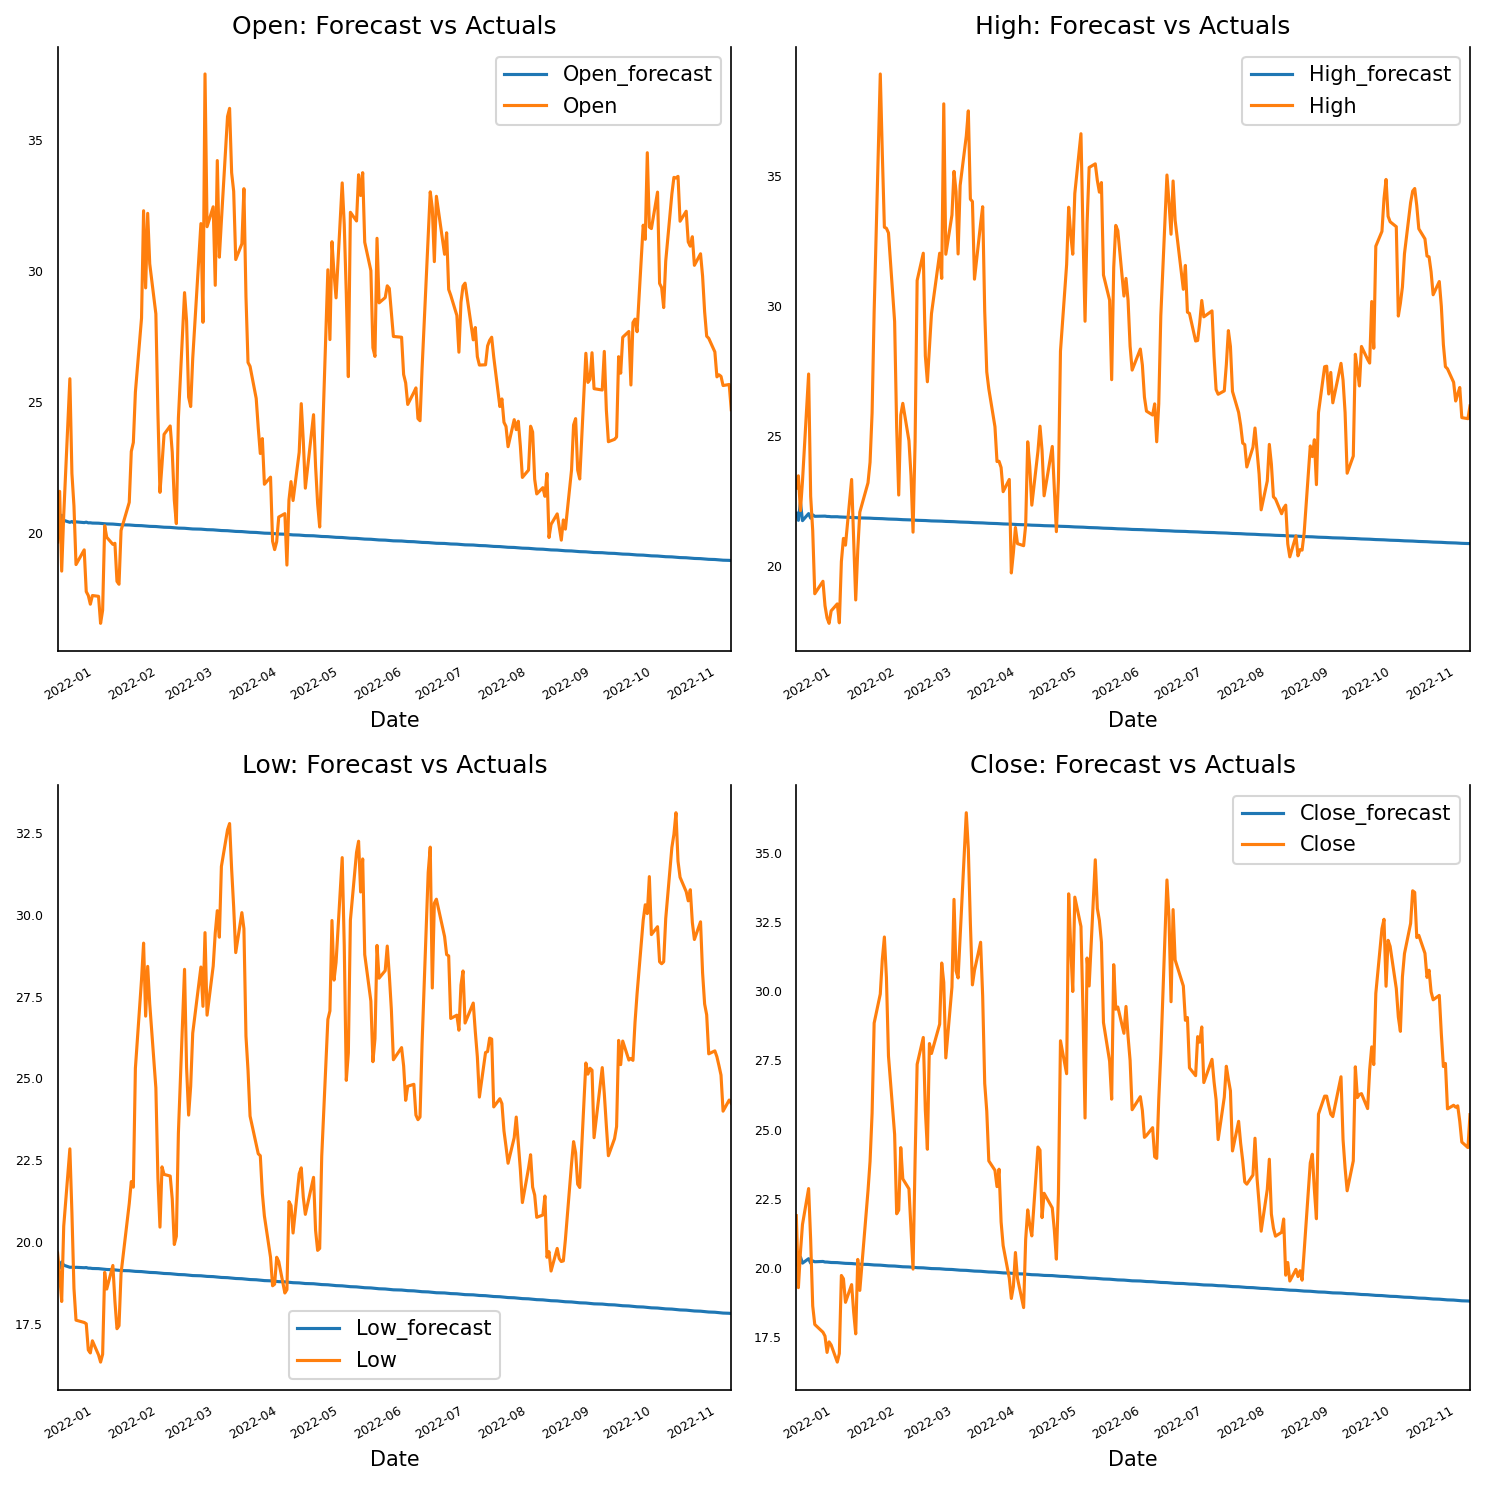

In [123]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [124]:
# make predictions on future dates
pred = model_fitted.forecast(model_fitted.y, steps=nobs)
pred = pd.DataFrame(pred, columns = df.columns+ '_pred')

pred = pd.DataFrame(pred, columns=df.columns+ '_pred')
def invert_transformation(df_differenced, pred):
  forecast = pred.copy()
  columns = df.columns
  for col in columns:
    forecast[str(col)+'_pred'] = df[col].iloc[-1] +   forecast[str(col) +'_pred'].cumsum()
  return forecast

output = invert_transformation(df_differenced, pred)

output = pd.DataFrame(output['Close_pred'])

d = df.tail(nobs)
d.reset_index(inplace = True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], periods = (len(d) + 1), freq = 'd', closed = 'right')}))
d.set_index('Date', inplace = True)
d = d.tail(nobs)
output.index = d.index
print(output)

            Close_pred
Date                  
2022-11-09   25.347037
2022-11-10   25.612672
2022-11-11   25.631630
2022-11-12   25.406685
2022-11-13   25.566111
...                ...
2023-06-20   24.058159
2023-06-21   24.051654
2023-06-22   24.045149
2023-06-23   24.038644
2023-06-24   24.032140

[228 rows x 1 columns]


E:\Anaconda\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [125]:
from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(df_test['Close'], output))

MSE:  22.128610756415657
